# Generate artifacts for Dust GNILC model

This is a simplified version of the Dust GNILC template generation notebook which doesn't create any plots but just creates the artifacts at N_side 8192.

In [1]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [2]:
import os

# for jupyter.nersc.gov otherwise the notebook only uses 2 cores

os.environ["OMP_NUM_THREADS"] = "64"

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 2048
lmax = 2048

In [7]:
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["TT", "EE", "BB", "TE"]

change this to True   if you want to  run namaster on notebook 


In [10]:
namaster_on_nb = True

In [11]:
datadir = Path("data")

In [12]:
proddir = Path("production-data") / "dust_gnilc" / "raw"

In [13]:
gnilc_template = "varres"
dust_varresI = datadir / "COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"
dust_varresP = (
    datadir / f"COM_CompMap_IQU-thermaldust-gnilc-{gnilc_template}_2048_R3.00.fits"
)

In [14]:
if not dust_varresI.exists():
    !wget -O $dust_varresI https://portal.nersc.gov/project/cmb/pysm-data/dust_gnilc/inputs/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits

In [15]:
if not dust_varresP.exists():
    !wget -O $dust_varresP http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits

Transform maps to double precision for computations

In [16]:
m_planck_varres, h = hp.read_map(
    dust_varresP, [c + "_STOKES" for c in comp], dtype=np.float64, h=True
)
I_planck_varres, h = hp.read_map(dust_varresI, dtype=np.float64, h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [17]:
m_planck_varres <<= u.K_CMB
I_planck_varres <<= u.MJy / u.sr
m_planck_varres = m_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)
I_planck_varres = I_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

then we are ready to combine both maps into one single TQU map. 

In [18]:
m_planck_varres[0] = I_planck_varres
del I_planck_varres

### GAL080 Planck  mask 

we perform the monopole removal in a region outside  the Galactic plane.  


In [19]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

masking 0.7912631829579672 of the sky


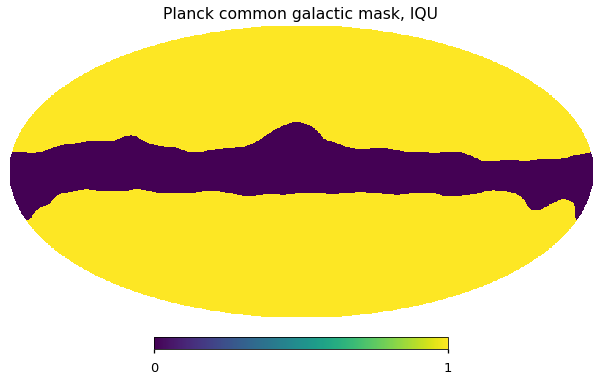

In [20]:
planck_mask = hp.read_map(planck_mask_filename, ["GAL080"])

planck_mask = np.int_(np.ma.masked_not_equal(planck_mask, 0.0).mask)
fsky = planck_mask.sum() / planck_mask.size
print(f"masking {fsky} of the sky")
hp.mollview(planck_mask, title=f"Planck common galactic mask, {comp}")

#### Monopole subtraction 


Section 2.2 of [Planck 2018 XII](https://arxiv.org/pdf/1807.06212.pdf) value reported:  0.13 MJy/sr 

we subtract this term only to the I map for   the pixels outside  the Galactic plane mask.

In [21]:
planck2018_monopole = (0.13 * u.MJy / u.sr).to(
    u.uK_RJ, equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

m_planck_varres[0][planck_mask] -= planck2018_monopole


We estimate how many pixels have I< P after we subtract the monopole 

In [22]:
maskmono = m_planck_varres[0] ** 2 < m_planck_varres[1] ** 2 + m_planck_varres[2] ** 2
print(
    f"{maskmono.sum() } pixels out of { maskmono.size} expected to be NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 expected to be NaNs in Log Pol Tens maps 


## Transform maps to Poltens quantities 

In [23]:
def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

In [24]:
log_pol_tens_varres = map_to_log_pol_tens(m_planck_varres.value)

/tmp/ipykernel_53026/1566809701.py:4: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
/tmp/ipykernel_53026/1566809701.py:5: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


Checking NaNs  on the Poltens map 

In [25]:
print(
    f"{np.isnan(log_pol_tens_varres[0]).sum()  } pixels out of { maskmono.size} are NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 are NaNs in Log Pol Tens maps 


In [26]:
for i in range(3):
    log_pol_tens_varres[i, np.isnan(log_pol_tens_varres[i])] = np.nanmedian(
        log_pol_tens_varres[i]
    )

Set all the NaNs to the map median value  


In [27]:
assert np.isnan(log_pol_tens_varres).sum() == 0

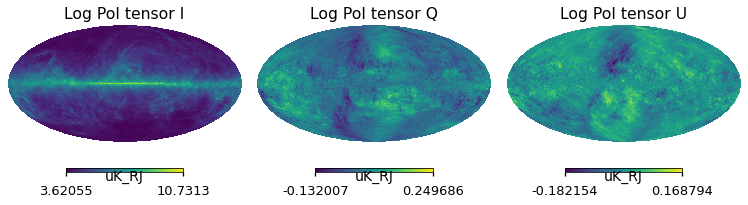

In [28]:
for i_pol, pol in components:
    hp.mollview(
        log_pol_tens_varres[i_pol],
        title="Log Pol tensor " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
    )

In [29]:
from scipy.optimize import curve_fit

In [30]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    return out

In [31]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """

    nside = hp.npix2nside(len(mask))
    # b = nmt.NmtBin.from_nside_linear(nside, 16)
    # leff = b.get_effective_ells()
    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0]])
        f_2 = nmt.NmtField(
            mask, m[1:].copy(), purify_b=True
        )  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0]])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [32]:
print("run anafast on full  sky  ")
ell, cl_norm, cl = run_anafast(log_pol_tens_varres, lmax)

run anafast on full  sky  


# (New) employing spectral indices from literature 

- https://arxiv.org/pdf/1801.04945.pdf and https://www.aanda.org/articles/aa/pdf/2016/09/aa28503-16.pdf
- 2 pivotal scales `ell1=110` and `ell2=800 ` 
- non zero TE  spectrum 



/tmp/ipykernel_53026/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_53026/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_53026/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_53026/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


(1e-07, 0.1)

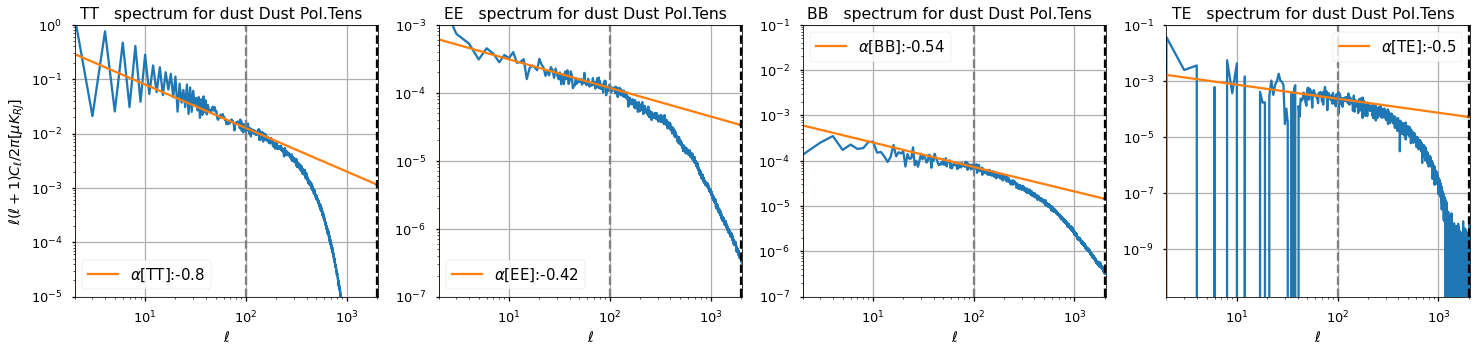

In [33]:
ell_fit_low = {"TT": 50, "EE": 50, "BB": 50, "TE": 50}
ell_fit_high = {"TT": 100, "EE": 100, "BB": 100, "TE": 100}
gamma_fit2 = {"TT": -0.8, "EE": -0.42, "BB": -0.54, "TE": -0.50}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {}, {}, {}, {}
plt.figure(figsize=(25, 5))
A_fit2 = {}
smallscales = []

ell_pivot = 2000
for ii, pol in enumerate(spectra_components):
    plt.subplot(141 + ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit2[pol] = np.fabs(A_fit[pol]) * ell_fit_high[pol] ** (
        gamma_fit[pol] - gamma_fit2[pol]
    )
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol])
    scaling = model(ell[:ell_pivot], A_fit2[pol], gamma_fit2[pol])
    scaling[:2] = 0
    plt.plot(ell[:ell_pivot], scaling, label=r"$\alpha$" + f"[{pol}]:{gamma_fit2[pol]}")
    smallscales.append(scaling)

    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
    plt.axvline(ell_pivot, linestyle="--", color="k")
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  ")

    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    plt.legend(fontsize=15)

for ii, pol in enumerate(spectra_components):
    # we change the EE and BB power laws
    xdata = np.arange(ell_fit_high[pol], ell.size)
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    plt.subplot(141 + ii)
    if pol == "TE":
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TE"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TE"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TT"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TT"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

plt.subplot(141)

plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.ylim(1e-5, 1e0)
plt.subplot(142)
plt.ylim(1e-7, 1e-3)
plt.subplot(143)
plt.ylim(1e-7, 1e-3)
plt.subplot(143)
plt.ylim(1e-7, 1e-1)

In [34]:
output_nside = 8192
output_lmax = 2 * output_nside
lmax = output_lmax
ell = np.arange(output_lmax + 1)
cl_norm = ell * (ell + 1) / np.pi / 2
cl_norm[:1] = 1

In [35]:
output_ell = np.arange(output_lmax + 1)[len(smallscales[0]) :]
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2

In [36]:
for ii, pol in enumerate(spectra_components):
    if pol == "TE":
        scaling = model(output_ell, A_fit2[pol], gamma_fit2["TE"])
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        scaling = model(output_ell, A_fit2[pol], gamma_fit2["TT"])
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

In [37]:
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[:1] = 1

In [38]:
len(smallscales[0]), len(output_cl_norm)

(16385, 16385)

In [39]:
cl_ss = [
    smallscales[ii]
    * sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10)
    / output_cl_norm
    for ii, pol in enumerate(spectra_components)
]

In [40]:
hp.write_cl(
    proddir / f"gnilc_dust_small_scales_logpoltens_cl_lmax{output_lmax}.fits.gz",
    cl_ss,
    dtype=np.complex128,
    overwrite=True,
)

In [ ]:
pysm3.utils.add_metadata(
    ["gnilc_dust_small_scales_logpoltens_cl_lmax16384.fits"], coord="G", unit="uK_RJ**2"
)

In [41]:
tsm = hp.read_map(datadir / "dust_gnilc_modulation_nside512.fits", 0)
psm = hp.read_map(datadir / "dust_gnilc_modulation_nside512.fits", 1)

In [42]:
for name, each_modulate in [("temperature", tsm), ("polarization", psm)]:
    alm = hp.map2alm(each_modulate, lmax=1.5 * 512, use_pixel_weights=True)
    hp.write_alm(
        proddir / f"gnilc_dust_{name}_modulation_alms_lmax{int(1.5*512):d}.fits.gz",
        alm,
        overwrite=True,
        out_dtype=np.float32,
    )

### Small scale injection 

In [43]:
largescale_lmax = 1024

In [44]:
alm_log_pol_tens_fullsky = hp.map2alm(
    log_pol_tens_varres, lmax=largescale_lmax, use_pixel_weights=True
)

ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)
for ii, pol in enumerate(spectra_components[:-1]):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)

    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)

In [45]:
hp.write_alm(
    proddir
    / f"gnilc_dust_largescale_template_logpoltens_alm_nside{nside}_lmax{largescale_lmax:d}_complex64.fits.gz",
    ii_LS_alm,
    lmax=largescale_lmax,
    out_dtype=np.complex64,
    overwrite=True,
)

In [ ]:
pysm.utils.add_metadata(
    [
        proddir
        / f"gnilc_dust_largescale_template_logpoltens_alm_nside{nside}_lmax{largescale_lmax:d}_complex64.fits.gz",
    ],
    coord="G",
    unit="mK_RJ",
)

## small scales included only outside the `GAL097` planck mask 
Employ observed data inside the Gal. Plane 


In [46]:
galplane_mask = hp.read_map(planck_mask_filename, ["GAL097"])

In [47]:
m_planck_varres[:, galplane_mask == 1] = 0

In [48]:
hp.write_map(
    proddir / "gnilc_dust_galplane.fits.gz",
    list(m_planck_varres.value) + [galplane_mask],
    fits_IDL=False,
    overwrite=True,
    coord="G",
    column_names=["TEMPERATURE", "Q_POLARISATION", "U_POLARISATION", "GALMASK"],
    column_units=["uK_RJ", "uK_RJ", "uK_RJ", ""],
    dtype=np.float32,
)